# 9 Команда
## Определение диких животных на фотографиях

**Цель проекта**: Разработка системы мониторинга и раннего обнаружения диких животных с использованием технологий компьютерного зрения. Проект направлен на повышение безопасности населения и защиту животных, таких как тигры и медведи, которые часто заходят в города.

Решение включает создание модели машинного обучения, способной идентифицировать присутствие диких животных на изображениях. Внедрение этой системы позволит оперативно информировать службы спасения и местные органы власти о появлении животных, минимизируя риски для людей и способствуя гуманному управлению популяцией диких животных.

## Состав команды

**Тимлид -  Кондрашов Александр**
+ Сбор данных: Овчинников Михаил, Можогин Сергей
+ Аугментация изображений: Калистратов Александр
+ Обучение предобученных нейронных сетей: Кондрашов Александр
+ Продакшн : Келарев Михаил
+ Ведение документации: Душенбаева Айдана

In [57]:
import torch
import os
from torchvision import transforms
from PIL import Image
from google.colab import drive
from natsort import natsorted
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader
import torch.nn as nn
from torch.optim import lr_scheduler
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import mobilenet_v2,squeezenet1_1
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, recall_score
import pandas as pd
import seaborn as sns
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Загрузка изображений

In [58]:
# Функция для открытия изображений
def open_images(path):
    img = [Image.open(os.path.join(path, filename)).convert("RGB")
           for filename in natsorted(os.listdir(path)) if filename.endswith('.jpg')]
    return img

# Функция для чтения меток
def open_file_txt(paths):
    labels = []
    for path in paths:
        with open(path, 'r') as f:
            for row in f:
                labels.extend(list(row.strip()))
    return list(map(int, labels))

# Визуализация изображений
def visualize_images(images, labels, count_of_images):
    for k, (img, label) in enumerate(zip(images, labels)):
        if k == count_of_images:
            break
        plt.imshow(img)
        plt.title(f"Метка: {label}")
        plt.axis('off')
        plt.show()


image_folder = '/content/drive/MyDrive/хакатон/-_9_--main/Images'
labels_folders = [
    '/content/drive/MyDrive/хакатон/-_9_--main/Labels_001-100.txt',
    '/content/drive/MyDrive/хакатон/-_9_--main/Labels_101-200.txt'
]
images = open_images(image_folder)
labels = open_file_txt(labels_folders)
visualize_images(images, labels, count_of_images=200)

Output hidden; open in https://colab.research.google.com to view.

## Подготовка данных к обучению

In [59]:
class RandomGaussianNoise(object):
    def __init__(self, mean=0.0, std=0.01):
        self.mean = mean
        self.std = std

    def __call__(self, img):
        if not torch.is_tensor(img):
            img = transforms.ToTensor()(img)
        noise = torch.randn(img.size()) * self.std + self.mean
        img = img + noise
        img = torch.clamp(img, 0., 1.)
        return img


def get_train_transform():
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.RandomRotation(degrees=10),
        RandomGaussianNoise(mean=0.0, std=0.01),
    ])


def get_val_transform():
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])


class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, images_dir, labels_file_1, labels_file_2, transform=None):
        self.images_dir = images_dir
        self.transform = transform

        files = [labels_file_1, labels_file_2]
        labels_list = []

        for file in files:
            with open(file, 'r') as f:
                labels_str = f.read().strip()
                labels_list.extend(list(labels_str))

        num_images = len(labels_list)
        self.image_paths = []
        self.labels = []
        # Надо использовать естественную сортировку
        image_files = natsorted(os.listdir(images_dir))

        for i in range(num_images):
            img_path = os.path.join(images_dir, image_files[i])
            if not os.path.isfile(img_path):
                raise FileNotFoundError(f"Не найден файл {img_path}")

            label = int(labels_list[i])
            self.image_paths.append(img_path)
            self.labels.append(label)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.image_paths)


class DataSplitter:
    def __init__(self, dataset, val_size=0.2, test_size=0.2, random_state=42):
        self.dataset = dataset
        self.val_size = val_size
        self.test_size = test_size
        self.random_state = random_state
        self.train_dataset = None
        self.val_dataset = None
        self.test_dataset = None

    def split_data(self):
        train_indices, temp_indices = train_test_split(
            range(len(self.dataset)), test_size=self.val_size + self.test_size, random_state=self.random_state, stratify=self.dataset.labels
        )
        val_size_adjusted = self.test_size / (self.val_size + self.test_size)
        val_indices, test_indices = train_test_split(
            temp_indices, test_size=val_size_adjusted, random_state=self.random_state, stratify=[self.dataset.labels[i] for i in temp_indices]
        )

        self.train_dataset = Subset(self.dataset, train_indices)
        self.val_dataset = Subset(self.dataset, val_indices)
        self.test_dataset = Subset(self.dataset, test_indices)
        return self.train_dataset, self.val_dataset, self.test_dataset

# Инициализация и разделение
images_dir = '/content/drive/MyDrive/хакатон/-_9_--main/Images'
labels_file_1 = '/content/drive/MyDrive/хакатон/-_9_--main/Labels_001-100.txt'
labels_file_2 = '/content/drive/MyDrive/хакатон/-_9_--main/Labels_101-200.txt'


# Создание датасета
dataset = CustomDataset(images_dir, labels_file_1, labels_file_2)
splitter = DataSplitter(dataset)
train_dataset, val_dataset, test_dataset = splitter.split_data()

# Применение трансформаций
train_dataset.dataset.transform = get_train_transform()
val_dataset.dataset.transform = get_val_transform()
test_dataset.dataset.transform = get_val_transform()

# Создание загрузчиков данных
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

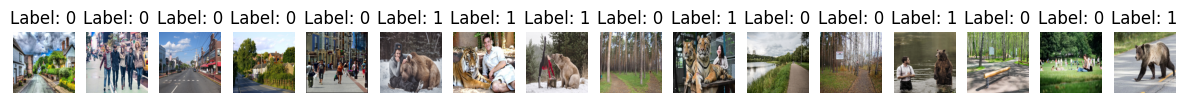

In [60]:
def visualize_samples(data_loader, class_names, num_images=5):
    inputs, labels = next(iter(data_loader))
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        img = inputs[i].permute(1, 2, 0).numpy()
        label = labels[i].item()
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {class_names[label]}")
        axes[i].axis('off')
    plt.show()
class_names = ['0', '1']
visualize_samples(test_loader, class_names=class_names, num_images=16)

## Обучение нейросети

In [61]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
  model.train()
  running_loss = 0.0
  running_corrects = 0
  processed_data = 0
  for inputs , labels  in train_loader:
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion (outputs , labels)
    loss.backward()
    optimizer.step()
    preds = torch.argmax(outputs, 1)
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)
    processed_data += inputs.size(0)
  scheduler.step()
  train_loss = running_loss / processed_data
  train_acc = running_corrects.numpy() / processed_data
  return train_loss, train_acc
def eval_epoch(model, val_loader, criterion):
  model.eval()
  running_loss = 0.0
  running_corrects = 0
  processed_size = 0
  for inputs, labels in val_loader:
    with torch.set_grad_enabled(False):
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      preds = torch.argmax(outputs, 1)
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)
    processed_size += inputs.size(0)
  val_loss = running_loss / processed_size
  val_acc = running_corrects.cpu().numpy() / processed_size
  return val_loss, val_acc
def predict(model, test_loader):
    running_corrects = 0
    processed_size = 0
    with torch.no_grad():
        logits = []
        preds = []
        answers = []

        for inputs, labels in test_loader:
            model.eval()
            outputs = model(inputs)
            logits.append(outputs)
            preds.append(torch.argmax(outputs, 1))
            answers.append(labels)
            running_corrects += torch.sum(torch.argmax(outputs, 1) == labels.data)
            processed_size += inputs.size(0)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    preds = torch.cat(preds, dim=-1).numpy()
    answers = torch.cat(answers, dim=-1).numpy()
    test_acc = running_corrects.numpy() / processed_size
    return answers, preds, probs, test_acc
def train(train, val, model, epochs, rate, criterion):
  history = []
  opt = torch.optim.Adam(model.parameters(), lr=rate)
  sch = lr_scheduler.StepLR(opt, step_size=5, gamma=0.1)
  for epoch in range(epochs):
    train_loss, train_acc = fit_epoch(model, train, criterion, opt, sch)
    val_loss, val_acc = eval_epoch(model, val, criterion)
    history.append((train_loss, train_acc, val_loss, val_acc))
  return history

In [62]:
weights_18 = ResNet18_Weights.DEFAULT
resnet_18 = resnet18(weights=weights_18)


for param in resnet_18.parameters():
    param.requires_grad = False

layers = list(resnet_18.children())
for layer in layers[-4:]:
    for param in layer.parameters():
        param.requires_grad = True
in_features = 512
out_features = 2
resnet_18.fc = nn.Linear(in_features, out_features)

In [63]:
ce = nn.CrossEntropyLoss()
lr = 3e-4

In [64]:
history_18 = train(train_loader,val_loader, model=resnet_18, epochs=5, rate = 3e-4, criterion=ce)

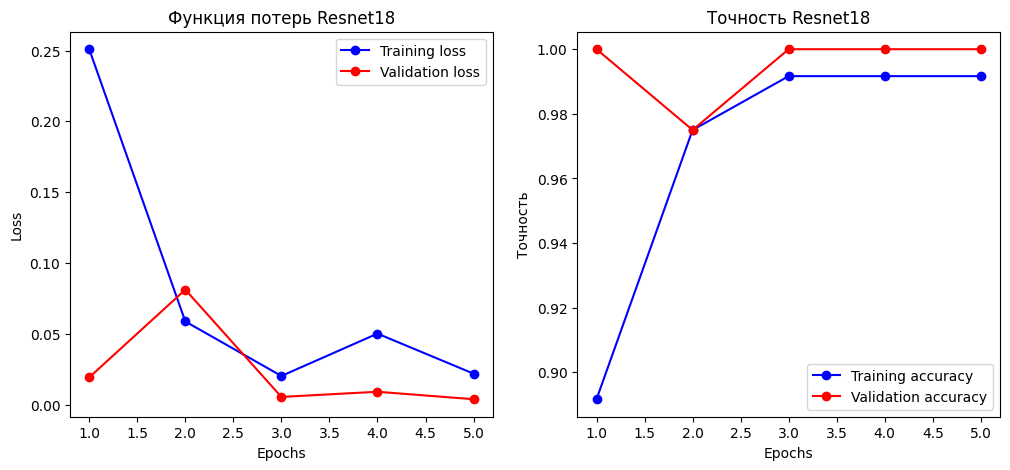

In [70]:
train_losses_18 = [x[0] for x in history_18]
train_accuracies_18 = [x[1] for x in history_18]
val_losses_18 = [x[2] for x in history_18]
val_accuracies_18 = [x[3] for x in history_18]

epochs_18 = range(1, len(history_18) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_18, train_losses_18, 'bo-', label='Training loss')
plt.plot(epochs_18, val_losses_18, 'ro-', label='Validation loss')
plt.title('Функция потерь Resnet18')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_18, train_accuracies_18, 'bo-', label='Training accuracy')
plt.plot(epochs_18, val_accuracies_18, 'ro-', label='Validation accuracy')
plt.title('Точность Resnet18')
plt.xlabel('Epochs')
plt.ylabel('Точность')
plt.legend()
plt.show()

In [39]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, recall_score
import pandas as pd
import seaborn as sns

In [66]:
y_test, preds, probs, test_acc = predict(resnet_18, test_loader)

In [67]:
f1_score(y_test, preds)

1.0

In [68]:
weights_50 = ResNet50_Weights.DEFAULT
resnet_50 = resnet50(weights=weights_50)


for param in resnet_50.parameters():
    param.requires_grad = False

layers = list(resnet_50.children())
for layer in layers[-4:]:
    for param in layer.parameters():
        param.requires_grad = True
in_features = 2048
out_features = 2
resnet_50.fc = nn.Linear(in_features, out_features)

In [69]:
history_50 = train(train_loader,val_loader, model=resnet_50, epochs=5, rate = 3e-3, criterion=ce)

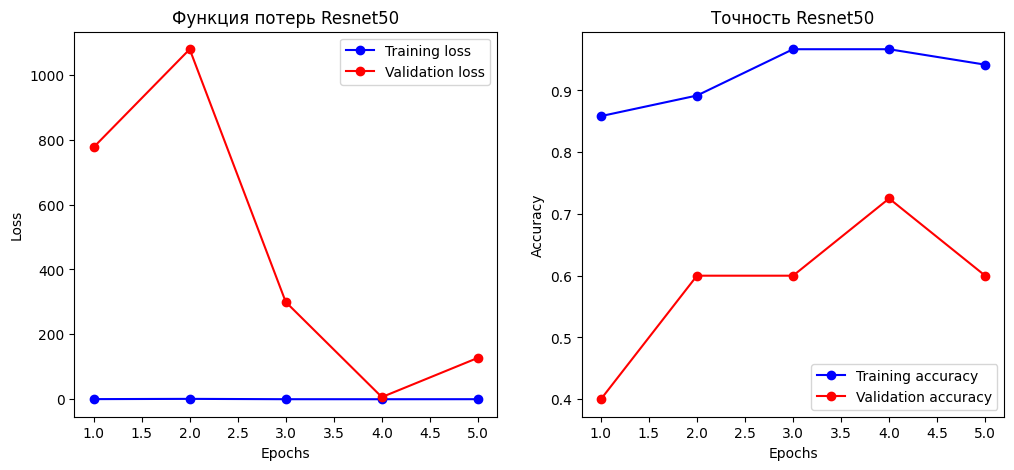

In [71]:
train_losses_50 = [x[0] for x in history_50]
train_accuracies_50 = [x[1] for x in history_50]
val_losses_50 = [x[2] for x in history_50]
val_accuracies_50 = [x[3] for x in history_50]
# Количество эпох
epochs_50 = range(1, len(history_50) + 1)

# Построение графика функции потерь
plt.figure(figsize=(12, 5))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(epochs_50, train_losses_50, 'bo-', label='Training loss')
plt.plot(epochs_50, val_losses_50, 'ro-', label='Validation loss')
plt.title('Функция потерь Resnet50')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(epochs_50, train_accuracies_50, 'bo-', label='Training accuracy')
plt.plot(epochs_50, val_accuracies_50, 'ro-', label='Validation accuracy')
plt.title('Точность Resnet50')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [44]:
mobilenet = mobilenet_v2(pretrained=True)
mobilenet.classifier = nn.Sequential(nn.Dropout(p=0.5, inplace=False),
                  nn.Linear(in_features=mobilenet.classifier[1].in_features, out_features=2, bias=True))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 75.5MB/s]


In [72]:
net_mobile = train(train_loader,val_loader, model=mobilenet, epochs=3, rate = 3e-4, criterion=ce)

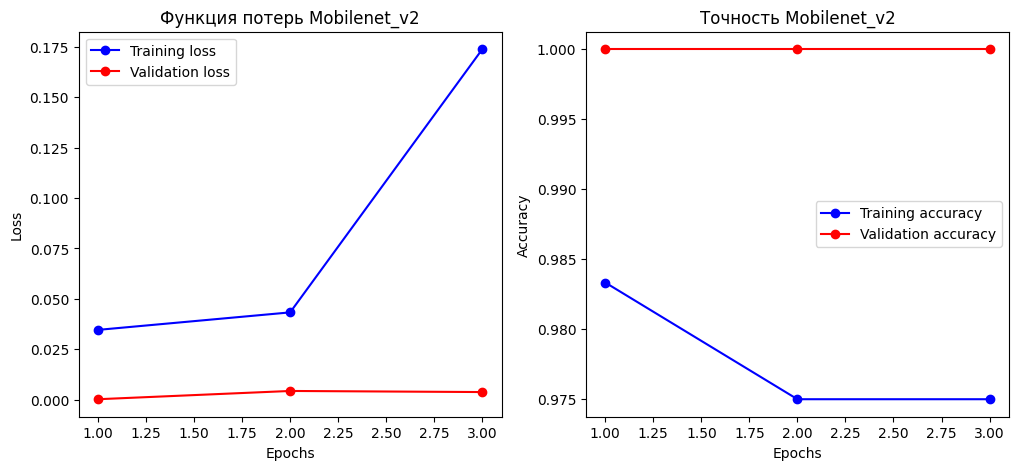

In [73]:
train_losses_net = [x[0] for x in net_mobile]
train_accuracies_net = [x[1] for x in net_mobile]
val_losses_net = [x[2] for x in net_mobile]
val_accuracies_net = [x[3] for x in net_mobile]

epochs_net = range(1, len(net_mobile) + 1)

# Построение графика функции потерь
plt.figure(figsize=(12, 5))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(epochs_net, train_losses_net, 'bo-', label='Training loss')
plt.plot(epochs_net, val_losses_net, 'ro-', label='Validation loss')
plt.title('Функция потерь Mobilenet_v2')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(epochs_net, train_accuracies_net, 'bo-', label='Training accuracy')
plt.plot(epochs_net, val_accuracies_net, 'ro-', label='Validation accuracy')
plt.title('Точность Mobilenet_v2')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [74]:
y_test, preds, probs, test_acc = predict(mobilenet,test_loader)
f1_score(y_test, preds)


1.0

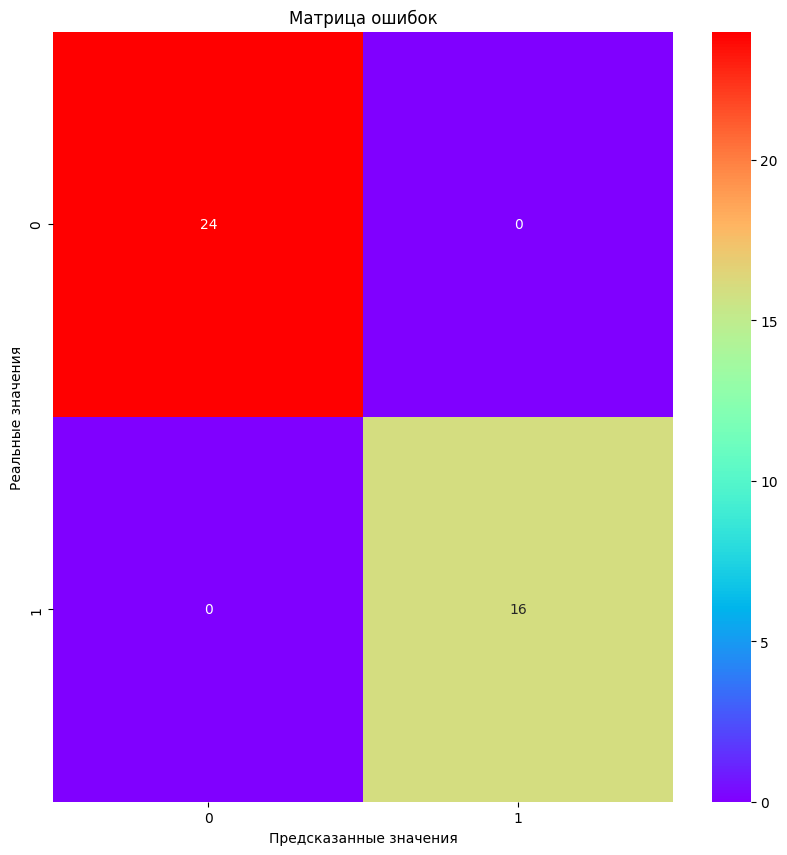

In [48]:
conf_mx = pd.DataFrame(confusion_matrix(preds, y_test))

fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(conf_mx, annot= True , fmt="d",  cmap='rainbow', ax=ax)
ax.set_title('Матрица ошибок для MobileNet');
ax.set_xlabel('Предсказанные значения')
ax.set_ylabel('Реальные значения');
plt.show()

In [75]:
squezze = squeezenet1_1(pretrained=True)
squezze.classifier[1] = nn.Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))
squezze.num_classes = 2
for param in squezze.parameters():
    param.requires_grad = True

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [76]:
squezze_model = train(train_loader,val_loader, model=squezze, epochs=4, rate = 3e-3, criterion=ce)

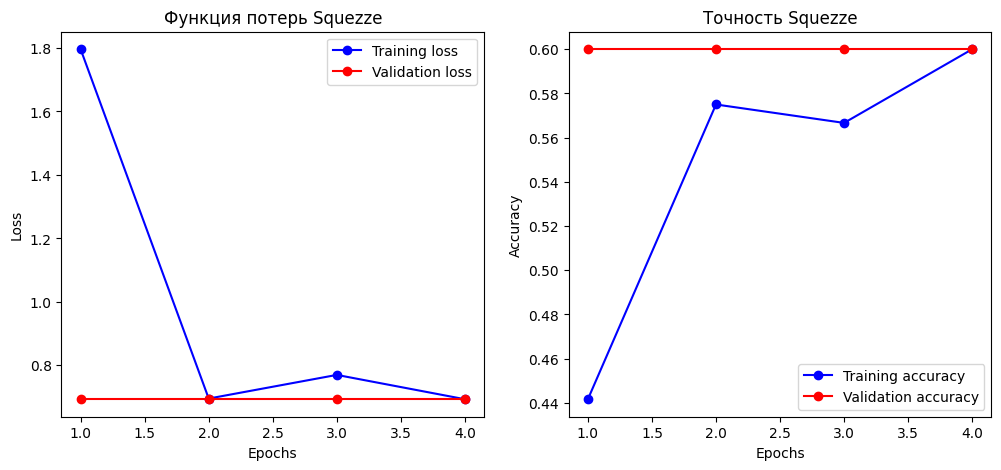

In [77]:
train_losses_squezze = [x[0] for x in squezze_model]
train_accuracies_squezze = [x[1] for x in squezze_model]
val_losses_squezze = [x[2] for x in squezze_model]
val_accuracies_squezze = [x[3] for x in squezze_model]

epochs_squezze = range(1, len(squezze_model) + 1)

# Построение графика функции потерь
plt.figure(figsize=(12, 5))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(epochs_squezze, train_losses_squezze, 'bo-', label='Training loss')
plt.plot(epochs_squezze, val_losses_squezze, 'ro-', label='Validation loss')
plt.title('Функция потерь Squezze')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(epochs_squezze, train_accuracies_squezze, 'bo-', label='Training accuracy')
plt.plot(epochs_squezze, val_accuracies_squezze, 'ro-', label='Validation accuracy')
plt.title('Точность Squezze')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [78]:
print(f'resnet_18: {round(history_18[-1][-1],2)}')
print(f'resnet_50: {round(history_50[-1][-1],2)}')
print(f'squezze: {round(squezze_model[-1][-1],2)}')
print(f'mobilenet: {round(net_mobile[-1][-1],2)}')

resnet_18: 1.0
resnet_50: 0.6
squezze: 0.6
mobilenet: 1.0


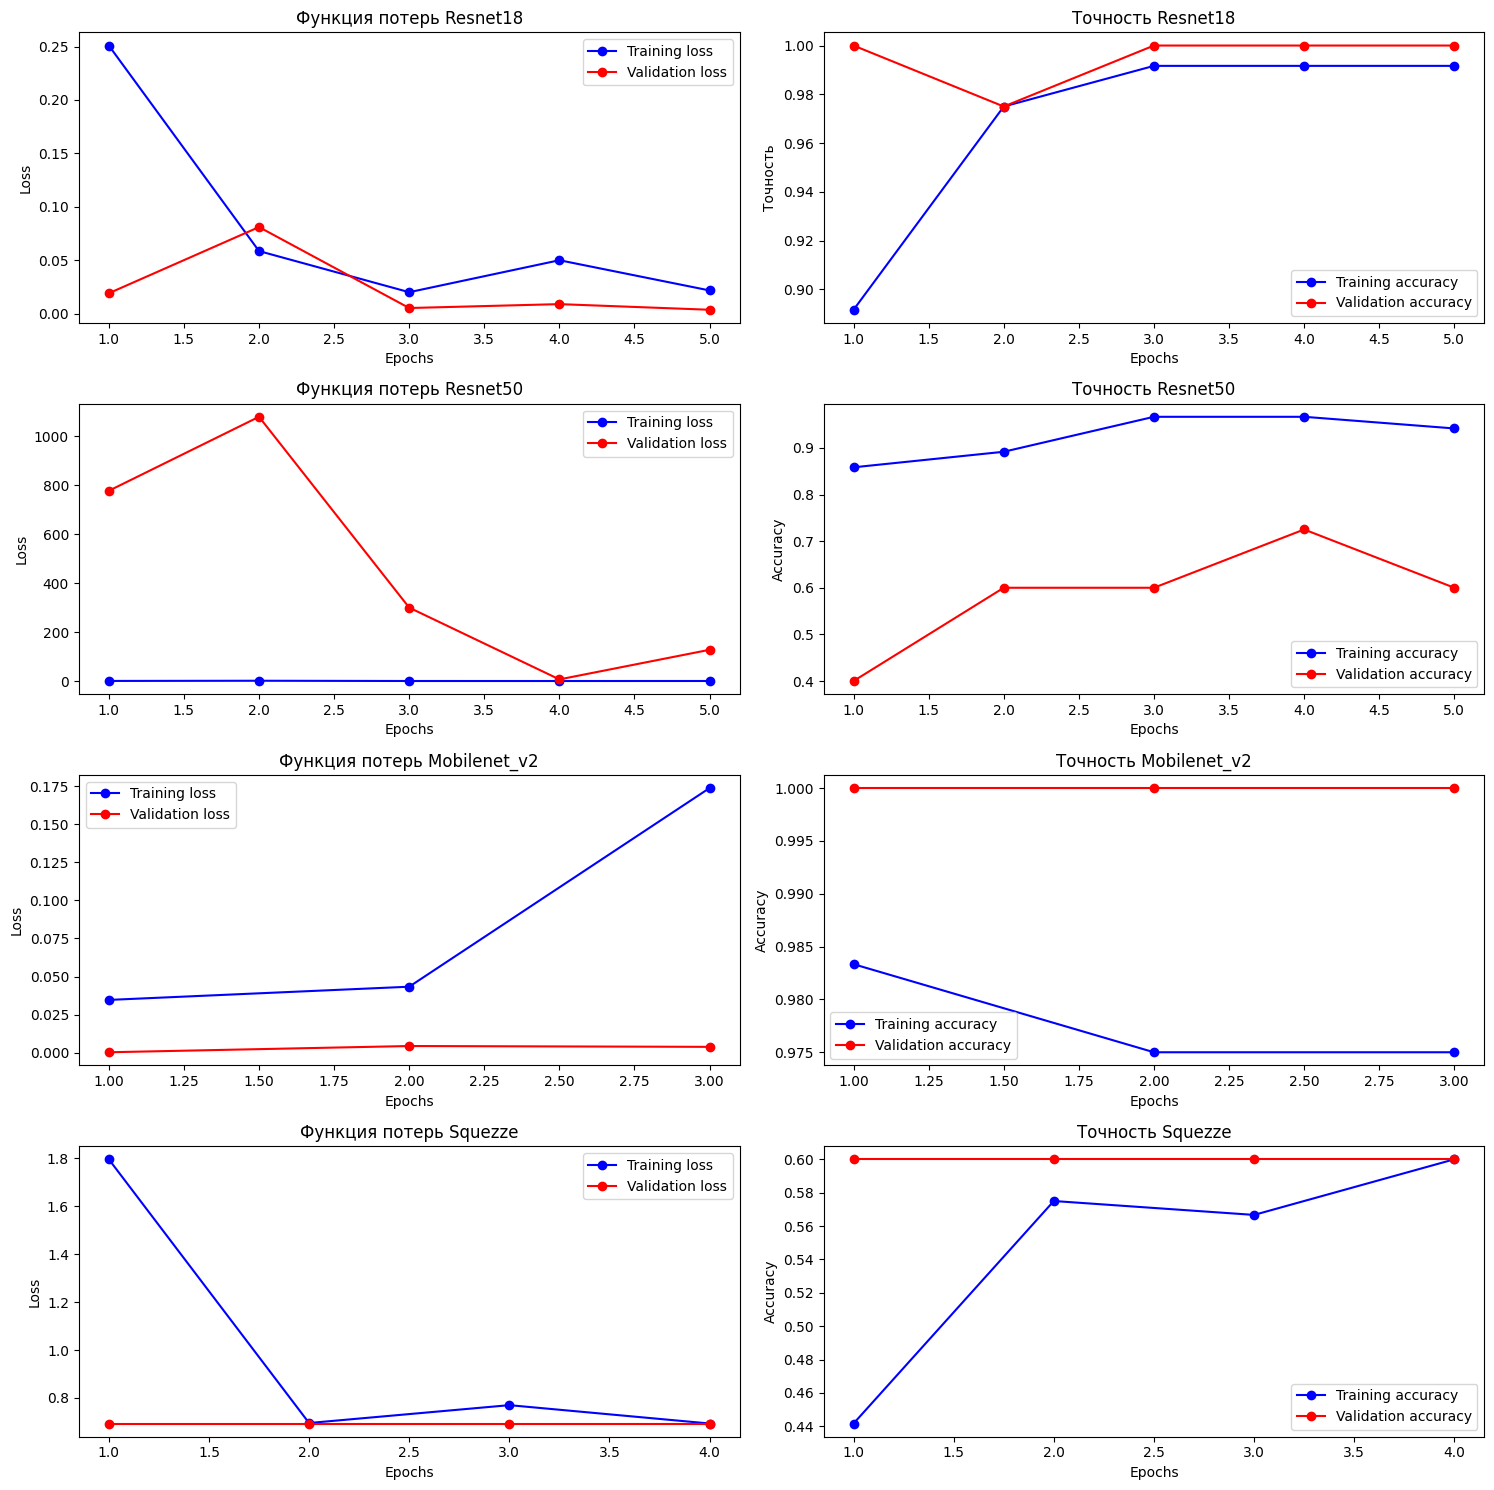

In [83]:
fig, axes = plt.subplots(nrows = 4, ncols = 2, figsize=(15,15))
plt.subplots_adjust(hspace=0.5)
axes[0,0].plot(epochs_18, train_losses_18, 'bo-', label='Training loss')
axes[0,0].plot(epochs_18, val_losses_18, 'ro-', label='Validation loss')
axes[0,0].set_title('Функция потерь Resnet18')
axes[0,0].set_xlabel('Epochs')
axes[0,0].set_ylabel('Loss')
axes[0,0].legend()
axes[0,1].plot(epochs_18, train_accuracies_18, 'bo-', label='Training accuracy')
axes[0,1].plot(epochs_18, val_accuracies_18, 'ro-', label='Validation accuracy')
axes[0,1].set_title('Точность Resnet18')
axes[0,1].set_xlabel('Epochs')
axes[0,1].set_ylabel('Точность')
axes[0,1].legend()
axes[1,0].plot(epochs_50, train_losses_50, 'bo-', label='Training loss')
axes[1,0].plot(epochs_50, val_losses_50, 'ro-', label='Validation loss')
axes[1,0].set_title('Функция потерь Resnet50')
axes[1,0].set_xlabel('Epochs')
axes[1,0].set_ylabel('Loss')
axes[1,0].legend()
axes[1,1].plot(epochs_50, train_accuracies_50, 'bo-', label='Training accuracy')
axes[1,1].plot(epochs_50, val_accuracies_50, 'ro-', label='Validation accuracy')
axes[1,1].set_title('Точность Resnet50')
axes[1,1].set_xlabel('Epochs')
axes[1,1].set_ylabel('Accuracy')
axes[1,1].legend()
axes[2,0].plot(epochs_net, train_losses_net, 'bo-', label='Training loss')
axes[2,0].plot(epochs_net, val_losses_net, 'ro-', label='Validation loss')
axes[2,0].set_title('Функция потерь Mobilenet_v2')
axes[2,0].set_xlabel('Epochs')
axes[2,0].set_ylabel('Loss')
axes[2,0].legend()
axes[2,1].plot(epochs_net, train_accuracies_net, 'bo-', label='Training accuracy')
axes[2,1].plot(epochs_net, val_accuracies_net, 'ro-', label='Validation accuracy')
axes[2,1].set_title('Точность Mobilenet_v2')
axes[2,1].set_xlabel('Epochs')
axes[2,1].set_ylabel('Accuracy')
axes[2,1].legend()
axes[3,0].plot(epochs_squezze, train_losses_squezze, 'bo-', label='Training loss')
axes[3,0].plot(epochs_squezze, val_losses_squezze, 'ro-', label='Validation loss')
axes[3,0].set_title('Функция потерь Squezze')
axes[3,0].set_xlabel('Epochs')
axes[3,0].set_ylabel('Loss')
axes[3,0].legend()
axes[3,1].plot(epochs_squezze, train_accuracies_squezze, 'bo-', label='Training accuracy')
axes[3,1].plot(epochs_squezze, val_accuracies_squezze, 'ro-', label='Validation accuracy')
axes[3,1].set_title('Точность Squezze')
axes[3,1].set_xlabel('Epochs')
axes[3,1].set_ylabel('Accuracy')
axes[3,1].legend()
plt.tight_layout()
plt.show()


## Выбор лучшей модели

F1-score : 1.0


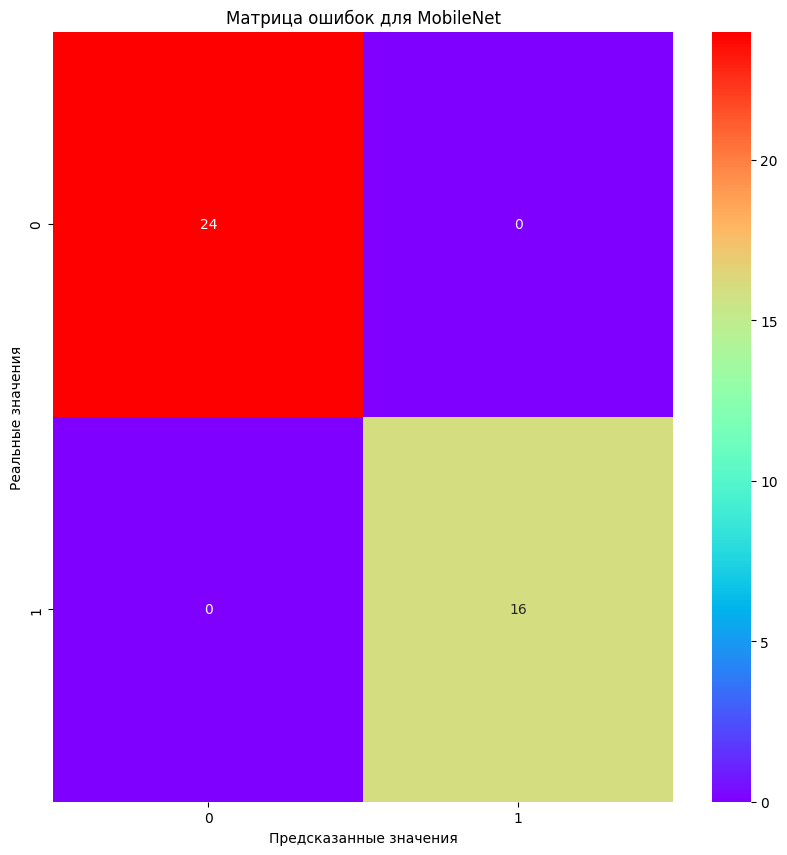

In [86]:
y_test, preds, probs, test_acc = predict(resnet_18, test_loader)



print(f'F1-score : {f1_score(y_test, preds)}')
conf_mx = pd.DataFrame(confusion_matrix(preds, y_test))

fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(conf_mx, annot= True , fmt="d",  cmap='rainbow', ax=ax)
ax.set_title('Матрица ошибок для MobileNet');
ax.set_xlabel('Предсказанные значения')
ax.set_ylabel('Реальные значения');
plt.show()

In [88]:
torch.save(resnet18,'/content/drive/MyDrive/хакатон/-_9_--main/' + 'resnet_18.pth')